## Binômes :
- ***Abdelkrim HALIMI***
- ***Hatem AYED***

In [1]:
#Permet de modifier les fichiers de la bib gymnasium pour debug
%load_ext autoreload
%autoreload 2

# Outlook

In this notebook, using BBRL, you will study the effect of partial observability 
on the CartPoleContinuous-v1 environment, using either the DDPG or the TD3 algorithm.

To emulate partial observability, you will design dedicated wrappers. Then you will study
whether extending the input of the agent policy and critic with a memory of previous states
and its output with action chunks can help solve the partial observability issue. This will
also be achieved by designing other temporal extension wrappers.

# Installation

In [2]:
# Prepare the environment
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=False)

import os
import copy
import numpy as np
import gymnasium as gym
import math
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl_utils.nn import build_mlp, setup_optimizer, soft_update_params
from bbrl_utils.notebook import setup_tensorboard
from bbrl.visu.plot_policies import plot_policy
from omegaconf import OmegaConf

/mnt/c/Cours-Sorbonne/M2/UE_DEEP/.venv/lib/python3.10/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401


# Temporal modification wrappers

The CartPoleContinuous-v1 environment is a custom extension of 
[the CartPole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/) 
with continuous actions, between -1 and 1. It is defined in the bbrl_gymnasium library.

As in CartPole, the state of the system contains 4 variables:
- the position $x$,
- the velocity $\dot{x}$,
- the angle of the pole $\theta$,
- the angular velocity $\dot{\theta}$.

To emulate partial observability in CartPoleContinuous-v1, you will hide the $\dot{x}$ and $\dot{\theta}$ features, 
by filtering them out of the state of the environment. This is implemented with the ```FeatureFilterWrapper```.

To compensate for partial observability, you will extend the architecture of the agent 
with a memory of previous states and its output with action chunks.
This is implemented with to wrappers, the ```ObsTimeExtensionWrapper``` and the ```ActionTimeExtensionWrapper```.

## The FeatureFilterWrapper

The FeatureFilterWrapper removes a feature from the output observation when calling the ```reset()``` and ```step(action)``` functions.
The index of the removed feature is given when building the object.

To hide the $\dot{x}$ and $\dot{\theta}$ features from the CartPoleContinuous-v1 environment, 
the idea is to call the wrapper twice, using something like
```env = FeatureFilterWrapper(FeatureFilterWrapper(inner_env, 3), 1)``` where ```inner_env``` is the CartPoleContinuous-v1 environment.

### Exercise 1: code the FeatureFilterWrapper class below.

Beyond rewriting the ```reset()``` and ```step(action)``` functions, beware of adapting the observation space and its shape.

In [3]:
class FeatureFilterWrapper(gym.ObservationWrapper):
    def __init__(self, env, index):
        super().__init__(env)
        self.index = index
        self.filter_observation()
    
    def filter_observation(self):
        old_space = self.observation_space
        low = np.delete(old_space.low, self.index)
        high = np.delete(old_space.high, self.index)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=old_space.dtype)
    
    def observation(self,obs):
        return np.delete(obs, self.index)

## The ObsTimeExtensionWrapper

When facing a partially observable environment, training with RL a reactive agent which just selects an action based on the current observation
is not guaranteed to reach optimality. An option to mitigate this fundamental limitation is to equip the agent with a memory of the past.

One way to do so is to use a recurrent neural network instead of a feedforward one to implement the agent: the neural network contains
some memory capacity and the RL process may tune this internal memory so as to remember exactly what is necessary from the
past observation. This has been done many times using an LSTM, see for instance 
[this early paper](https://proceedings.neurips.cc/paper/2001/file/a38b16173474ba8b1a95bcbc30d3b8a5-Paper.pdf).

Another way to do so is to equip the agent with a list-like memory of the past observations 
and to extend the critic and policy to take as input the current observation and the previous ones.
This removes the difficulty of learning an adequate representation of the past, but this results in 
enlarging the input size of the actor and critic networks. This can only be done if the required memory
horizon to behave optimally is small enough.

In the case of the CartPoleContinuous-v1 environment, one can see immediately that a memory of the previous
observation is enough to compensate for the absence of the derivative features, since $\dot{a} \approx (a_{t} - a_{t-1})$.

So we will extend the RL agent with a memory of size 1.

Though it may not be intuitive at first glance, the simplest way to do so is to embed the environment into a wrapper
which contains the required memory and produces the extended observations. This way, the RL agent will naturally be built
with an extended observation space, and the wrapper will be in charge of concatenating the memorized
observation from the previous step with the current observation received from the inner environment when calling the ```step(action)``` function.
When calling the ```reset()``` function, the memory of observations should be reinitialized with null observations.

### Exercise 2: code the ObsTimeExtensionWrapper class below.

Beyond rewriting the ```reset()``` and ```step(action)``` functions, beware of adapting the observation space and its shape.

In [4]:
class ObsTimeExtensionWrapper(gym.ObservationWrapper):
    def __init__(self, env, history_length=2):
        super().__init__(env)
        self.history_length = history_length
        self.history = []
        low = np.repeat(env.observation_space.low, self.history_length)
        high = np.repeat(env.observation_space.high, self.history_length)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=env.observation_space.dtype)
    
    def reset(self, *args, **kwargs):
        obs, info = self.env.reset(*args, **kwargs)
        self.history = [np.zeros_like(obs)] * (self.history_length - 1)
        self.history.append(obs)
        return np.concatenate(self.history), info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.history.append(obs)
        self.history = self.history[-self.history_length:]
        return np.concatenate(self.history), reward, terminated, truncated, info

## The ActionTimeExtensionWrapper

It has been observed that, in partially observable environments, preparing to play a sequence of actions and only playing
the first can be better than only preparing for one action. The difference comes from the fact that the critic evaluates
sequences of actions, even if only the first is played in practice.

Similarly to the ObsTimeExtensionWrapper, the corresponding behavior can be implemented with a wrapper.
The size of the action space of the extended environment should be 
M times the size of the action space of the inner environment. This ensures that the policy and the critic
will consider extended actions.
Besides, the ```step(action)``` function should receive an extended actions of size M times the size of an action,
and should only transmit the first action to the inner environment.


### Exercise 3: code the ActionTimeExtensionWrapper class below.

Beyond rewriting the ```reset()``` and ```step(action)``` functions, beware of adapting the action space and its shape.

In [5]:
class ActionTimeExtensionWrapper(gym.ActionWrapper):
    def __init__(self, env, action_horizon=2):
        super().__init__(env)
        self.action_horizon = action_horizon
        self.action_space = gym.spaces.Box(
            low=np.tile(env.action_space.low, self.action_horizon),
            high=np.tile(env.action_space.high, self.action_horizon),
            dtype=env.action_space.dtype
        )
    
    def action(self, action):
        return action[0]

## Test the Wrappers with some Assertions

In [6]:
class Test():
    def __init__(self):
        self.action = 0
        self.env = gym.make("CartPoleContinuous-v1")
        self.obs_original, _ = self.env.reset(seed=0)
        self.observation_original, _, _, _, _ = self.env.step(self.action)
        
    def test_featureFilterWrapper(self):
        env_filtered = FeatureFilterWrapper(FeatureFilterWrapper(self.env, 3), 1)
        obs_filtered, _ = env_filtered.reset(seed=0)
        observation_filtered, _, _, _, _ = env_filtered.step(self.action)
        self.obs_original = np.delete(self.obs_original, [1, 3])
        self.observation_original = np.delete(self.observation_original, [1, 3])

        assert np.all(self.obs_original == obs_filtered), f"Expected {self.obs_original}, got {obs_filtered} in reset()"
        assert np.all(self.observation_original == observation_filtered), f"Expected {self.observation_original}, got {observation_filtered} in action()"

    def test_obsTimeExtensionWrapper(self):
        env_filtered = ObsTimeExtensionWrapper(FeatureFilterWrapper(FeatureFilterWrapper(self.env, 3), 1), 2)
        obs_filtered, _ = env_filtered.reset(seed=0)
        observation_filtered, _, _, _, _ = env_filtered.step(self.action)

        assert np.all(self.obs_original == obs_filtered[2:]), f"Expected {self.obs_original}, got {obs_filtered[2:]} in reset()"
        assert np.all(self.observation_original == observation_filtered[2:]), f"Expected {self.observation_original}, got {observation_filtered[2:]} in action()"

        assert len(obs_filtered) == 4, f"Expected 2, got {len(obs_filtered)}"
        assert len(observation_filtered) == 4, f"Expected 2, got {len(observation_filtered)}"

    def test_actionTimeExtensionWrapper(self):
        env_filtered = ActionTimeExtensionWrapper(ObsTimeExtensionWrapper(FeatureFilterWrapper(FeatureFilterWrapper(self.env, 3), 1)), action_horizon=3)
        obs_filtered, _ = env_filtered.reset(seed=0)
        self.action = [np.random.uniform(-1, 1), np.random.uniform(-1, 1), np.random.uniform(-1, 1)]
        obs_filtered, _, _, _, _ = env_filtered.step(self.action)
        assert env_filtered.action_space.shape[0] == 3, f"Expected 3, got {len(env_filtered.action_space)}"

    def run(self):
        print("[INFO] Running tests...")
        print("[INFO] Testing FeatureFilterWrapper...")
        self.test_featureFilterWrapper()
        print("[INFO] Testing ObsTimeExtensionWrapper...")
        self.test_obsTimeExtensionWrapper()
        print("[INFO] Testing ActionTimeExtensionWrapper...")
        self.test_actionTimeExtensionWrapper()
        print("[INFO] All tests passed")

In [7]:
test_class = Test()
test_class.run()

Matplotlib backend: inline
[INFO] Running tests...
[INFO] Testing FeatureFilterWrapper...
[INFO] Testing ObsTimeExtensionWrapper...
[INFO] Testing ActionTimeExtensionWrapper...
[INFO] All tests passed


## Launching tensorboard to visualize the results

In [8]:
setup_tensorboard("./outputs/tblogs")

# Experimental study

To run the experiments below, you can use the [DDPG](https://arxiv.org/pdf/1509.02971.pdf) 
or [TD3](http://proceedings.mlr.press/v80/fujimoto18a/fujimoto18a.pdf) algorithms.

You can just copy paste here the code you have used during the corresponding labs.
We only provide a suggested set of hyper-parameters working well on the CartPoleContinuous-v1 environment for DDPG.

## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a
tensorboard visualisation.

In [8]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 2,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.99,
        "buffer_size": 1e6,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 5000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10_000,
        "action_noise": 0.15,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
            # "actor_hidden_size": 256, # FOR LSTM
            # "critic_hidden_size": 256, # FOR LSTM
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
}

### Exercise 4:

You know have all the elements to study the impact of removing features from the environment
on the training performance, and the impact of temporally extending the agent in mitigating 
partial observability, both with observation and with action extension.

In practice, you should produce the following learning curves:

- a learning curve of your algorithm on the standard CartPoleContinuous-v1 environment with full observability,
- two learning curves, one from removing $\dot{x}$ from CartPoleContinuous-v1 and the other from removing $\dot{\theta}$, 
- one learning curve from removing both $\dot{x}$ and $\dot{\theta}$, 
- the same four learning curves as above, but adding each of the temporal extension wrappers, separately or combined.

The way to combine these learning curves in different figures is open to you but should be carefully considered
depending on the conclusions you want to draw. Beware of drawing conclusions from insufficient statistics.

Discuss what you observe and conclude from this study.

## Agents

In [9]:
class LSTMContinuousQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.is_q_function = True
        self.lstm = nn.LSTM(state_dim + action_dim, hidden_layers[0], batch_first=True)
        self.fc = build_mlp([hidden_layers[0]] + list(hidden_layers[1:]) + [1], activation=nn.ReLU())

    def forward(self, t):
        obs = self.get(("env/env_obs", t))
        action = self.get(("action", t))
        # Pour avoir le format que le lstm prend
        obs_act = torch.cat((obs, action), dim=1).unsqueeze(0)  

        lstm_out, _ = self.lstm(obs_act)
        lstm_out = lstm_out.squeeze(0)  

        q_value = self.fc(lstm_out).squeeze(-1)
        self.set((f"{self.prefix}q_value", t), q_value)


class LSTMContinuousDeterministicActor(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.lstm = nn.LSTM(state_dim, hidden_layers[0], batch_first=True)
        self.fc = build_mlp([hidden_layers[0]] + list(hidden_layers[1:]) + [action_dim], activation=nn.ReLU(), output_activation=nn.Tanh())

    def forward(self, t, **kwargs):
        # Pour avoir le format que le LSTM prend
        obs = self.get(("env/env_obs", t)).unsqueeze(0) 

        lstm_out, _ = self.lstm(obs)
        lstm_out = lstm_out.squeeze(0)  

        action = self.fc(lstm_out)
        self.set(("action", t), action)


In [11]:
class ContinuousQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.is_q_function = True
        self.model = build_mlp(
            [state_dim + action_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t):
        # Get the current state $s_t$ and the chosen action $a_t$
        obs = self.get(("env/env_obs", t))  # shape B x D_{obs}
        action = self.get(("action", t))  # shape B x D_{action}
        # Compute the Q-value(s_t, a_t)
        obs_act = torch.cat((obs, action), dim=1)  # shape B x (D_{obs} + D_{action})
        # Get the q-value (and remove the last dimension since it is a scalar)
        q_value = self.model(obs_act).squeeze(-1)
        self.set((f"{self.prefix}q_value", t), q_value)

class ContinuousDeterministicActor(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(
            layers, activation=nn.ReLU(), output_activation=nn.Tanh()
        )

    def forward(self, t, **kwargs):
        obs = self.get(("env/env_obs", t))
        action = self.model(obs)
        self.set(("action", t), action)

## Noise

In [10]:
from torch.distributions import Normal

class AddGaussianNoise(Agent):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, t, **kwargs):
        act = self.get(("action", t))
        dist = Normal(act, self.sigma)
        action = dist.sample()
        self.set(("action", t), action)


class AddOUNoise(Agent):
    """
    Ornstein-Uhlenbeck process noise for actions as suggested by DDPG paper
    """

    def __init__(self, std_dev, theta=0.15, dt=1e-2):
        super().__init__()
        self.theta = theta
        self.std_dev = std_dev
        self.dt = dt
        self.x_prev = 0

    def forward(self, t, **kwargs):
        act = self.get(("action", t))
        x = (
            self.x_prev
            + self.theta * (act - self.x_prev) * self.dt
            + self.std_dev * math.sqrt(self.dt) * torch.randn(act.shape)
        )
        self.x_prev = x
        self.set(("action", t), x)

In [13]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir /mnt/c/Cours-Sorbonne/M2/UE_DEEP/RLD/TME/PROJET_mini_2/outputs (started 0:00:14 ago; pid 30776)


In [11]:
mse = nn.MSELoss()


class Losses:
    @staticmethod
    def compute_critic_loss(cfg, reward, must_bootstrap, q_values, target_q_values):
        """Compute the DDPG critic loss from a sample of transitions

        :param cfg: The configuration
        :param reward: The reward (shape 2xB)
        :param must_bootstrap: Must bootstrap flag (shape 2xB)
        :param q_values: The computed Q-values (shape 2xB)
        :param target_q_values: The Q-values computed by the target critic (shape 2xB)
        :return: the loss (a scalar)
        """
        # Compute temporal difference
        q_vals = q_values[0]
        target_vals = target_q_values[1].detach()

        target = reward[1] + cfg["algorithm"]["discount_factor"]*target_vals*must_bootstrap[1]
        loss = mse(q_vals, target)

        return loss
        # assert False, 'Not implemented yet'

    @staticmethod
    def compute_actor_loss(q_values):
        """Returns the actor loss

        :param q_values: The q-values (shape 2xB)
        :return: A scalar (the loss)
        """
        # To be completed...
        return -torch.mean(q_values[0])

In [12]:
class UselessWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def reset(self, *args, **kwargs):
        return self.env.reset(*args, **kwargs)
    
    def step(self, action):
        return self.env.step(action)

In [13]:
class DDPG(EpochBasedAlgo):
    def __init__(self, cfg, env_wrappers=[]):
        super().__init__(cfg, env_wrappers=env_wrappers)

        # we create the critic and the actor, but also an exploration agent to
        # add noise and a target critic. The version below does not use a target
        # actor as it proved hard to tune, but such a target actor is used in
        # the original paper.

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        print("Obs size : ", obs_size, "Action size : ", act_size)
        
        self.critic = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic/")
        self.target_critic = copy.deepcopy(self.critic).with_prefix("target-critic/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        # As an alternative, you can use `AddOUNoise`
        # noise_agent = AddOUNoise(cfg.algorithm.action_noise)
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor

        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic = TemporalAgent(self.critic)
        self.t_target_critic = TemporalAgent(self.target_critic)

        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic)

In [14]:
def run_ddpg(ddpg: DDPG):
    for rb in ddpg.iter_replay_buffers():
        rb_workspace = rb.get_shuffled(ddpg.cfg.algorithm.batch_size)

        ddpg.t_critic(rb_workspace, t=0, n_steps=2)
        with torch.no_grad():
            ddpg.t_actor(rb_workspace, t=0, n_steps=2)
            ddpg.t_target_critic(rb_workspace, t=0, n_steps=2)
        

        q_values, terminated, reward, action, target_q_values = rb_workspace[
            "critic/q_value", "env/terminated", "env/reward", "action", "target-critic/q_value"
        ]
    
        # Determines whether values of the critic should be propagated
        must_bootstrap = ~terminated
        critic_loss = Losses.compute_critic_loss(ddpg.cfg, reward, must_bootstrap, q_values, target_q_values)      

        # Gradient step (critic)
        ddpg.logger.add_log("critic_loss", critic_loss, ddpg.nb_steps)
        ddpg.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.critic.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.critic_optimizer.step()

        # Compute the actor loss
        
        ddpg.t_actor(rb_workspace, t=0, n_steps=2)
        ddpg.t_critic(rb_workspace, t=0, n_steps=2)
        q_values = rb_workspace["critic/q_value"]

        actor_loss = Losses.compute_actor_loss(q_values)
        # Gradient step (actor)
        ddpg.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.actor.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.actor_optimizer.step()

        # Soft update of target q function
        soft_update_params(
            ddpg.critic, ddpg.target_critic, ddpg.cfg.algorithm.tau_target
        )
        
        # Evaluate the actor if needed
        if ddpg.evaluate():
            if ddpg.cfg.plot_agents:
                plot_policy(
                    ddpg.actor,
                    ddpg.eval_env,
                    ddpg.best_reward,
                    str(ddpg.base_dir / "plots"),
                    ddpg.cfg.gym_env.env_name,
                    stochastic=False,
                )

In [32]:
env_wrappers = [
    # retirer les velocity et angle de l'observation
    lambda env: FeatureFilterWrapper(env, 3),  
    lambda env: FeatureFilterWrapper(env, 1), 
    # Ajouter mémoire d'observation
    lambda env: ObsTimeExtensionWrapper(env, history_length=4),  
    # Ajouter séquence d'actions
    lambda env: ActionTimeExtensionWrapper(env, action_horizon=8),
    # lambda env : UselessWrapper(env)  
] 
ddpg = DDPG(OmegaConf.create(params), env_wrappers)
run_ddpg(ddpg)

Obs size :  8 Action size :  8


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
ddpg.visualize_best()

## Experiments

In [20]:
def run_ddpg_n_times(nb_run=5, wrappers=[]):
    seeds = [1353, 65824, 92997, 28333] # Random seeds
    for i in range(nb_run):
        params["algorithm"]["seed"] = seeds[i]
        print(f"Running with seed {params['algorithm']['seed']}")
        ddpg = DDPG(OmegaConf.create(params), wrappers)
        run_ddpg(ddpg)

In [ ]:
run_ddpg_n_times(nb_run=4, wrappers=[])

In [ ]:
run_ddpg_n_times(nb_run=4, wrappers=[lambda env: FeatureFilterWrapper(env, 3)])

In [ ]:
run_ddpg_n_times(
    nb_run=4, 
    wrappers=[
    lambda env: FeatureFilterWrapper(env, 3),  
    lambda env: FeatureFilterWrapper(env, 1), 
    lambda env: ObsTimeExtensionWrapper(env, history_length=4),  
])

In [21]:
run_ddpg_n_times(
    nb_run=4, 
    wrappers=[
    lambda env: FeatureFilterWrapper(env, 3),  
    lambda env: FeatureFilterWrapper(env, 1), 
    lambda env: ObsTimeExtensionWrapper(env, history_length=4),  
    lambda env: ActionTimeExtensionWrapper(env, action_horizon=8),
])

Running with seed 1353
Obs size :  8 Action size :  6


  0%|          | 0/5000 [00:00<?, ?it/s]

Running with seed 65824
Obs size :  8 Action size :  6


  0%|          | 0/5000 [00:00<?, ?it/s]

Running with seed 92997
Obs size :  8 Action size :  6


  0%|          | 0/5000 [00:00<?, ?it/s]

Running with seed 28333
Obs size :  8 Action size :  6


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
run_ddpg_n_times(
    nb_run=1, 
    wrappers=[
    lambda env: FeatureFilterWrapper(env, 1),     
    lambda env: ObsTimeExtensionWrapper(env, history_length=4),  
])

In [ ]:
run_ddpg_n_times(nb_run=5, wrappers=[lambda env: ObsTimeExtensionWrapper(env, history_length=2)])
run_ddpg_n_times(nb_run=5, wrappers=[lambda env: ObsTimeExtensionWrapper(env, history_length=4)])
run_ddpg_n_times(nb_run=5, wrappers=[lambda env: ObsTimeExtensionWrapper(env, history_length=6)])

In [ ]:
run_ddpg_n_times(nb_run=5, wrappers=[lambda env: ObsTimeExtensionWrapper(env, history_length=8)])

In [ ]:
run_ddpg_n_times(nb_run=4, wrappers=[lambda env: ActionTimeExtensionWrapper(env, action_horizon=2)])
run_ddpg_n_times(nb_run=4, wrappers=[lambda env: ActionTimeExtensionWrapper(env, action_horizon=4)])

In [15]:
import matplotlib.pyplot as plt
import pandas as pd 
import os

class Utils:
    @staticmethod
    def moving_average(data, window_size, mode="same"):       
        return np.convolve(data, np.ones(window_size)/window_size, mode=mode)

    @staticmethod
    def get_data(path):
        data = pd.read_csv(path)
        return data["Step"], data["Value"]
    
    @staticmethod
    def normalize_shapes(listes, window_size=20, add_moving_average=True, skip_moving_average_indices=[]):
        listes_copy = copy.deepcopy(listes)
        if add_moving_average:
            for sub_liste in listes_copy:
                for i, element in enumerate(sub_liste):
                    if i not in skip_moving_average_indices:
                        sub_liste[i] = (element[0], Utils.moving_average(element[1], window_size))

        min_shape = min(map(len, [element[1] for sub_liste in listes_copy for element in sub_liste]))
        for sub_liste in listes_copy:
            for i, element in enumerate(sub_liste):
                sub_liste[i] = (element[0], element[1][:min_shape])

        return listes_copy

    @staticmethod
    def correct_seq_length(liste, min_shape=None):
        liste = copy.deepcopy(liste)
        min_shape = min(map(len, [element[1] for element in liste])) if min_shape is None else min_shape
        for i, result in enumerate(liste):
            liste[i] = (result[0][:min_shape], result[1][:min_shape])
        return liste 

In [16]:
root = os.getcwd()

results_no_wrapper = Utils.get_data(f"{root}/data/no_wrappers.csv")
results_no_wrappers = [results_no_wrapper] + [Utils.get_data(f"{root}/data/no_wrappers_{i}.csv") for i in range(2,6)]

results_time_extension_2 = Utils.get_data(f"{root}/data/time_extension_2.csv")
results_time_extensions_2 = [results_time_extension_2] + [Utils.get_data(f"{root}/data/time_extension_2_{i}.csv") for i in range(2,6)]

results_time_extension_4 = Utils.get_data(f"{root}/data/time_extension_4.csv")
results_time_extensions_4 = [results_time_extension_4] + [Utils.get_data(f"{root}/data/time_extension_4_{i}.csv") for i in range(2,6)]


results_time_extension_6 = Utils.get_data(f"{root}/data/time_extension_6.csv")
results_time_extensions_6 = [results_time_extension_6] + [Utils.get_data(f"{root}/data/time_extension_6_{i}.csv") for i in range(2,6)]

results_time_extension_8 = Utils.get_data(f"{root}/data/time_extension_8.csv")
results_time_extensions_8 = [results_time_extension_8] + [Utils.get_data(f"{root}/data/time_extension_8_{i}.csv") for i in range(2,6)]


results_action_extension_2 = Utils.get_data(f"{root}/data/action_extension_2.csv")
results_action_extensions_2 = [results_action_extension_2] + [Utils.get_data(f"{root}/data/action_extension_2_{i}.csv") for i in range(2,6)]

results_action_extension_4 = Utils.get_data(f"{root}/data/action_extension_4.csv")
results_action_extensions_4 = [results_action_extension_4] + [Utils.get_data(f"{root}/data/action_extension_4_{i}.csv") for i in range(2,6)]

results_action_extension_6 = Utils.get_data(f"{root}/data/action_extension_6.csv")



results_removed_index_1_TE2 = Utils.get_data(f"{root}/data/removed_1_time_extension_2.csv")
results_removed_index_3_TE2 = Utils.get_data(f"{root}/data/removed_3_time_extension_2.csv")
results_removed_index_3_TE4 = Utils.get_data(f"{root}/data/removed_index_3_TE4.csv")

results_removed_index_3_1_TE2 = Utils.get_data(f"{root}/data/removed_3_1_time_extension_2.csv")
results_removed_index_3_1_TE4 = Utils.get_data(f"{root}/data/removed_index_3_1_TE4.csv")
results_removed_indexs_3_1_TE4 = [results_removed_index_3_1_TE4] + [Utils.get_data(f"{root}/data/removed_index_3_1_TE4_{i}.csv") for i in range(2,6)]

results_removed_index_1 = Utils.get_data(f"{root}/data/removed_index_1.csv")
results_removed_indexs_1 = [results_removed_index_1] + [Utils.get_data(f"{root}/data/removed_index_1_{i}.csv") for i in range(2,6)]

results_removed_index_1_TE4 = Utils.get_data(f"{root}/data/removed_index_1_TE4.csv")
results_removed_indexs_1_TE4 = [results_removed_index_1_TE4] + [Utils.get_data(f"{root}/data/removed_index_1_TE4_{i}.csv") for i in range(2,6)]


results_removed_index_3 = Utils.get_data(f"{root}/data/removed_index_3.csv")
results_removed_indexs_3 = [results_removed_index_3] + [Utils.get_data(f"{root}/data/removed_index_3_{i}.csv") for i in range(2,6)]


results_removed_index_3_1 = Utils.get_data(f"{root}/data/removed_3_1.csv")

combined_AT_OBS_2 = Utils.get_data(f"{root}/data/combined_AT_OBS_2.csv")
combined_AT_OBS_4 = Utils.get_data(f"{root}/data/combined_AT_OBS_4.csv")
combined_AT_OBS_6 = Utils.get_data(f"{root}/data/combined_AT_OBS_6.csv")
combined_AT_OBS_8 = Utils.get_data(f"{root}/data/combined_AT_OBS_8.csv")

results_removed_indexs_3_1_TE4_AT = [combined_AT_OBS_4] + [Utils.get_data(f"{root}/data/combined_AT_TE4_{i}.csv") for i in range(2,6)]
results_removed_indexs_3_1_TE4_AT6 = [combined_AT_OBS_6] + [Utils.get_data(f"{root}/data/combined_AT6_TE4_{i}.csv") for i in range(2,6)]


In [17]:
def compare_results(res1, res2, figtitle, res1_title="Res1", res2_title="Res2"):
    min_shape1 = min(map(len, [element[1] for element in res1]))    
    min_shape2 = min(map(len, [element[1] for element in res2]))    
    res1, res2 = Utils.correct_seq_length([res1, res2], min_shape=min(min_shape1, min_shape2))

    plt.style.use("ggplot")
    plt.figure(figsize=(12,7))

    for i, result in enumerate(res1):
        if i == 0:  # Only label the first plot for blue
            plt.plot(result[0], result[1], color="blue", label=res1_title)
        else:
            plt.plot(result[0], result[1], color="blue")

    for i, result in enumerate(res2):
        if i == 0:  
            plt.plot(result[0], result[1], color="red", label=res2_title)
        else:
            plt.plot(result[0], result[1], color="red")

    plt.legend()
    plt.title(figtitle)
    plt.show()

def plot_multiple_results(results, fig_title, add_moving_average=False, window_size=20):

    results_moving_average = []
    for result in results:
        results_moving_average.append((result[0], Utils.moving_average(result[1], 20, mode="same")))

    results, results_moving_average = Utils.normalize_shapes([results, results_moving_average],  window_size=window_size, add_moving_average=False, skip_moving_average_indices=[0,1])
    seeds = [0, 1353, 65824, 92997, 28333]
    plt.style.use("ggplot")
    plt.figure(figsize=(12,7))
    for i, result in enumerate(results):
        # plot the moving average of the result with the same color, the moving is in results_moving_average
        if add_moving_average:
            plt.plot(result[0], result[1], label="Original", alpha=0.5)
        else:
            plt.plot(result[0], result[1], label=f"Run seed : {seeds[i]}")
    if add_moving_average:
        for result in results_moving_average:
            plt.plot(result[0], result[1], label="Moving average", linewidth=3)
            

    plt.legend()
    plt.title(fig_title)
    plt.show()
    

def comparing_wrappers_with_base_model(base_model, wrappers_model, wrappers_titles, fig_title):
    plt.style.use("ggplot")
    plt.figure(figsize=(12,7))
    plt.plot(base_model[0], base_model[1], label="Basic model with no wrappers")
    for i in range(len(wrappers_model)):
        plt.plot(wrappers_model[i][0], wrappers_model[i][1], label=wrappers_titles[i])
    plt.legend()
    plt.title(fig_title)
    plt.show()

plt.style.use("ggplot")

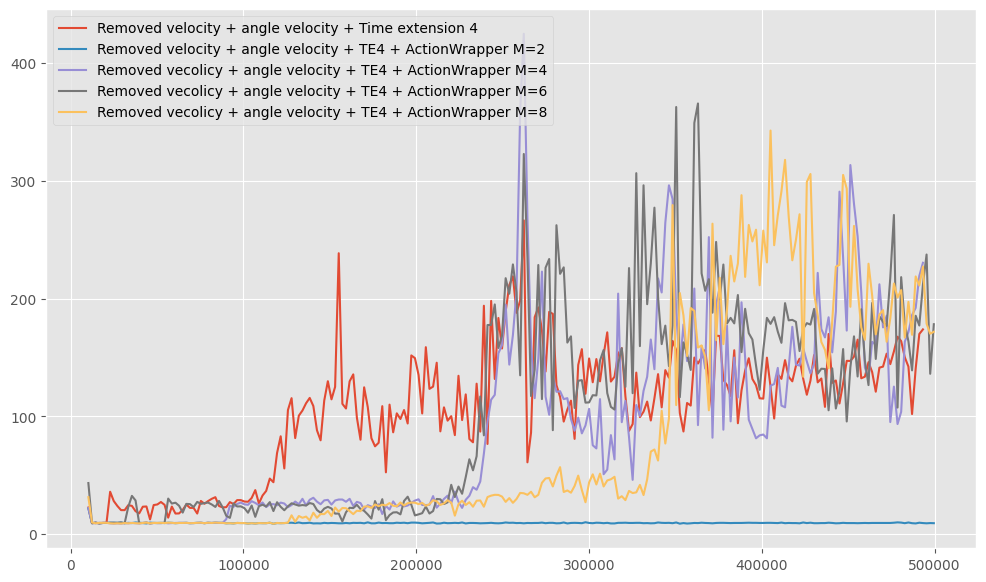

In [45]:
plt.style.use("ggplot")
plt.figure(figsize=(12,7))
plt.plot(results_removed_index_3_1_TE4[0], results_removed_index_3_1_TE4[1], label="Removed velocity + angle velocity + Time extension 4")
plt.plot(combined_AT_OBS_2[0], combined_AT_OBS_2[1], label="Removed velocity + angle velocity + TE4 + ActionWrapper M=2")
plt.plot(combined_AT_OBS_4[0], combined_AT_OBS_4[1], label="Removed vecolicy + angle velocity + TE4 + ActionWrapper M=4")
plt.plot(combined_AT_OBS_6[0], combined_AT_OBS_6[1], label="Removed vecolicy + angle velocity + TE4 + ActionWrapper M=6")
plt.plot(combined_AT_OBS_8[0], combined_AT_OBS_8[1], label="Removed vecolicy + angle velocity + TE4 + ActionWrapper M=8")
plt.legend()
plt.show()

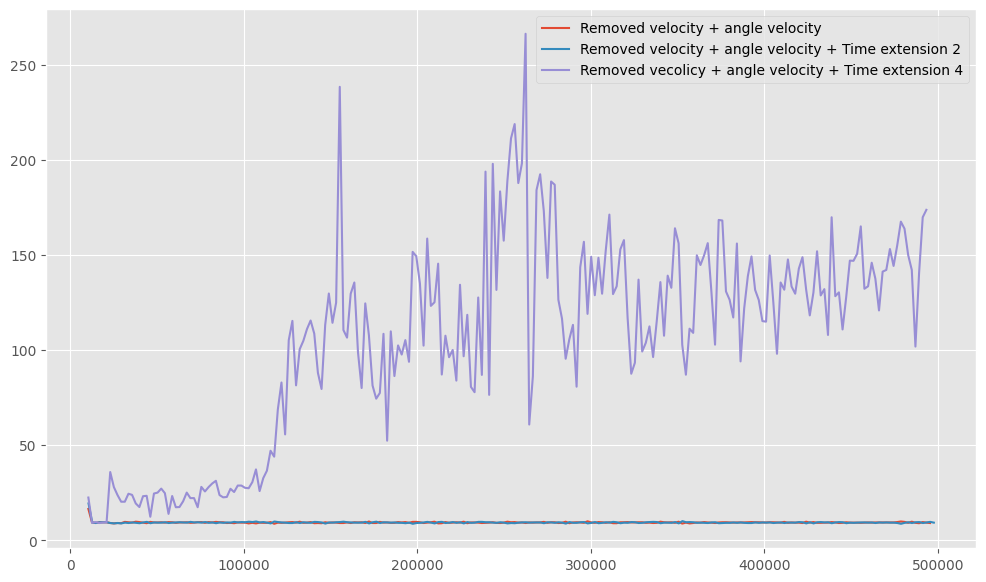

In [19]:
plt.figure(figsize=(12,7))
plt.plot(results_removed_index_3_1[0], results_removed_index_3_1[1], label="Removed velocity + angle velocity")
plt.plot(results_removed_index_3_1_TE2[0], results_removed_index_3_1_TE2[1], label="Removed velocity + angle velocity + Time extension 2")
plt.plot(results_removed_index_3_1_TE4[0], results_removed_index_3_1_TE4[1], label="Removed vecolicy + angle velocity + Time extension 4")
plt.legend()
plt.show()

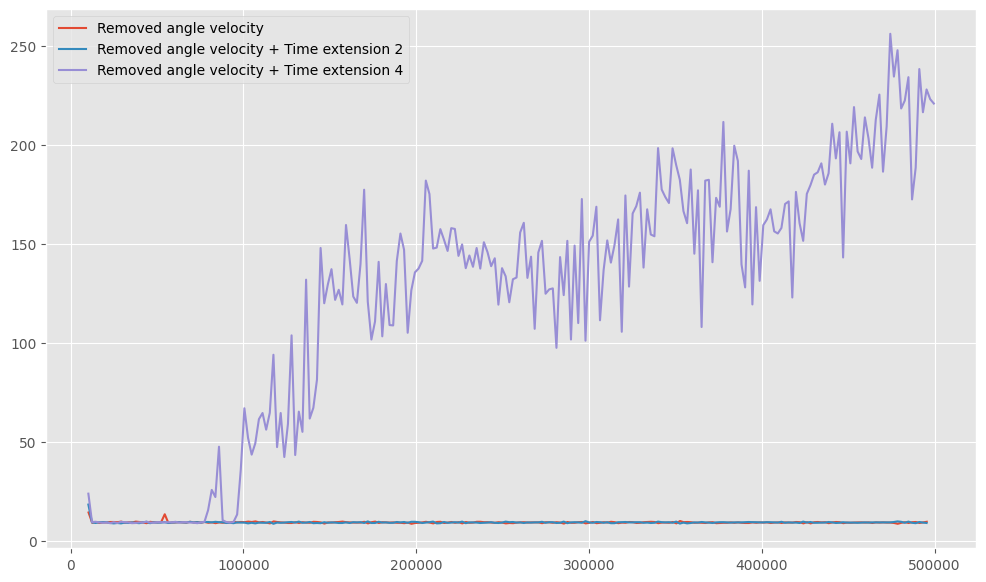

In [20]:
plt.figure(figsize=(12,7))
plt.plot(results_removed_index_3[0], results_removed_index_3[1], label="Removed angle velocity")
plt.plot(results_removed_index_3_TE2[0], results_removed_index_3_TE2[1], label="Removed angle velocity + Time extension 2")
plt.plot(results_removed_index_3_TE4[0], results_removed_index_3_TE4[1], label="Removed angle velocity + Time extension 4")
plt.legend()
plt.show()

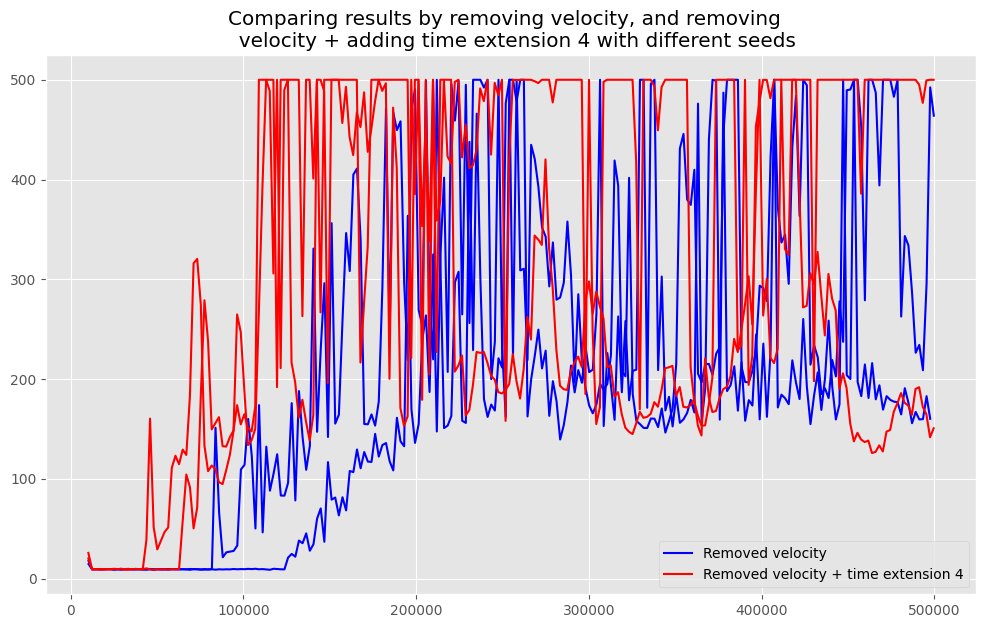

In [21]:
compare_results(results_removed_indexs_1, results_removed_indexs_1_TE4,
                 "Comparing results by removing velocity, and removing  \n  velocity + adding time extension 4 with different seeds"
                    , "Removed velocity", "Removed velocity + time extension 4")

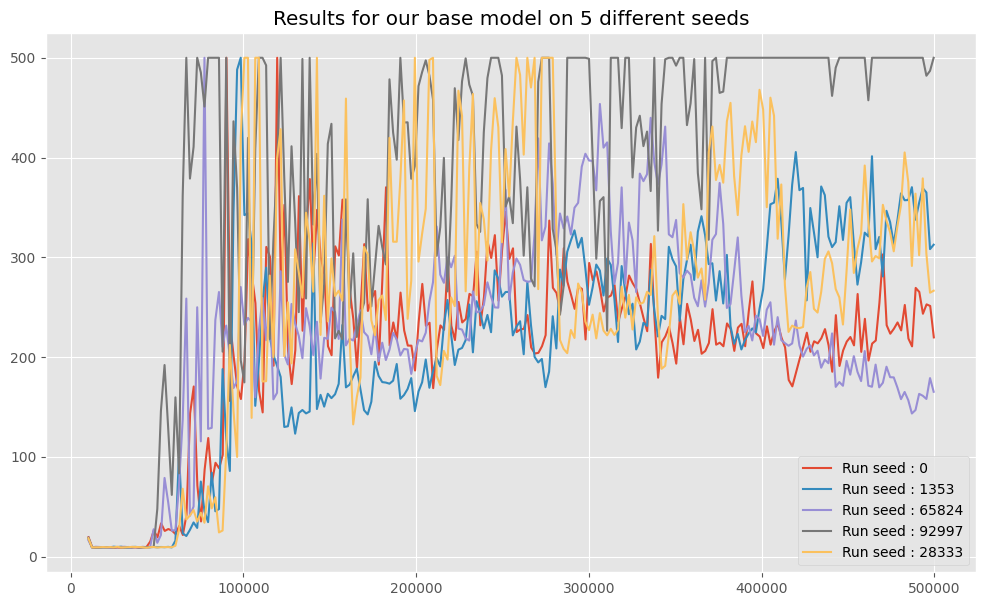

In [22]:
plot_multiple_results(results_no_wrappers, "Results for our base model on 5 different seeds", add_moving_average=False)

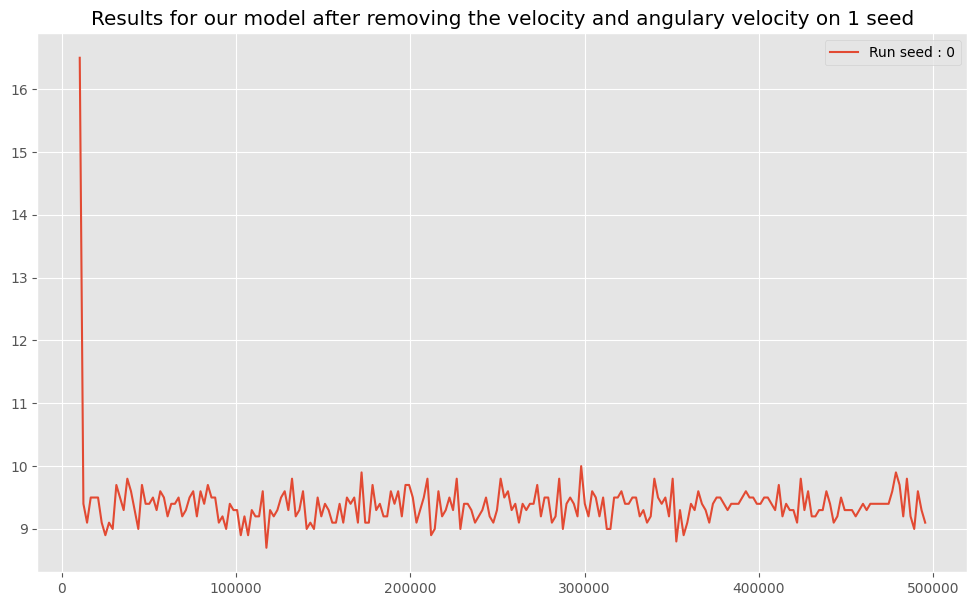

In [23]:
plot_multiple_results([results_removed_index_3_1], "Results for our model after removing the velocity and angulary velocity on 1 seed")

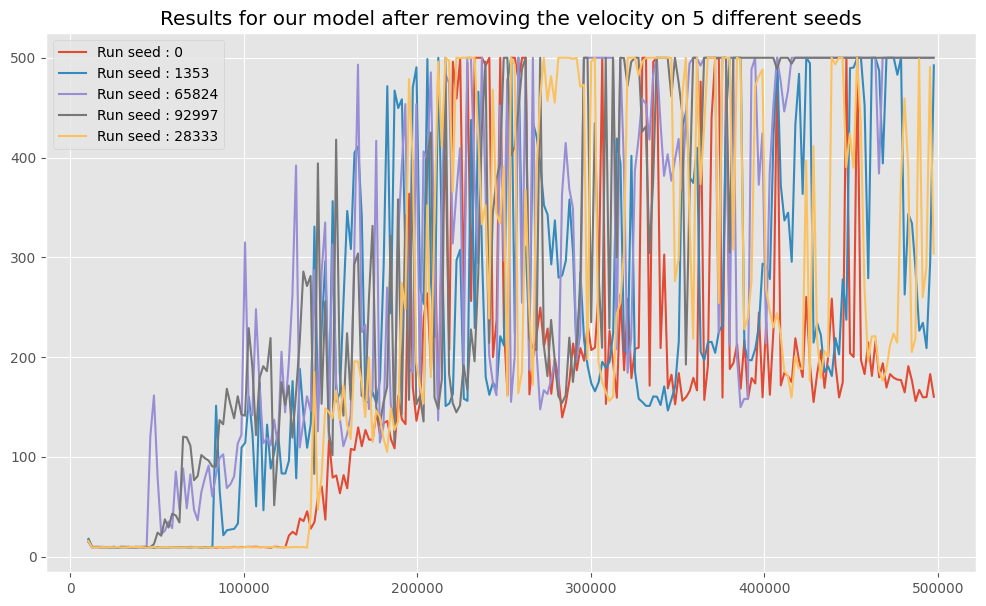

In [24]:
results_removed_indexs_1 = Utils.correct_seq_length(results_removed_indexs_1)
plot_multiple_results(results_removed_indexs_1, "Results for our model after removing the velocity on 5 different seeds", add_moving_average=False)


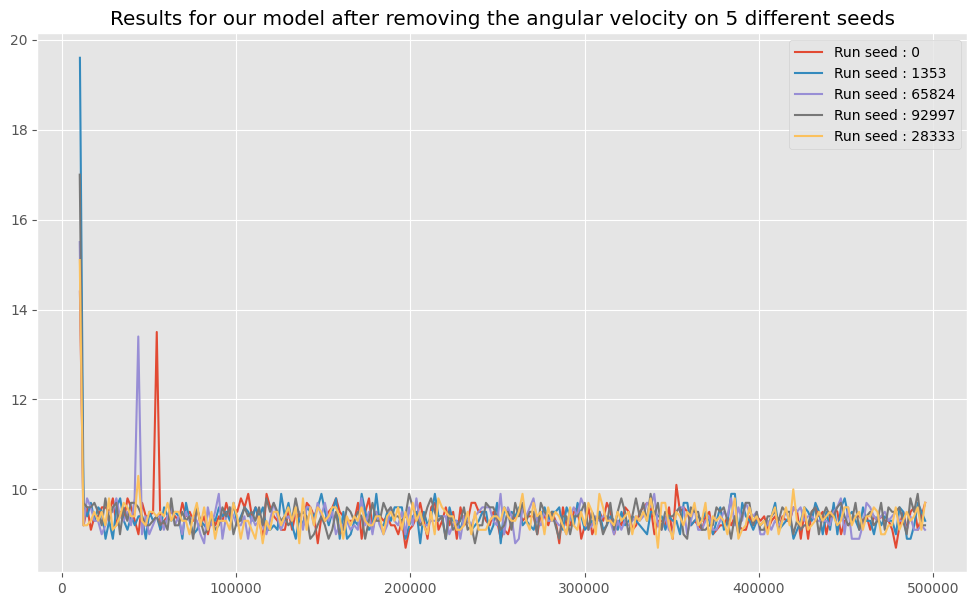

In [25]:
results_removed_indexs_3 = Utils.correct_seq_length(results_removed_indexs_3)
plot_multiple_results(results_removed_indexs_3, "Results for our model after removing the angular velocity on 5 different seeds", add_moving_average=False)

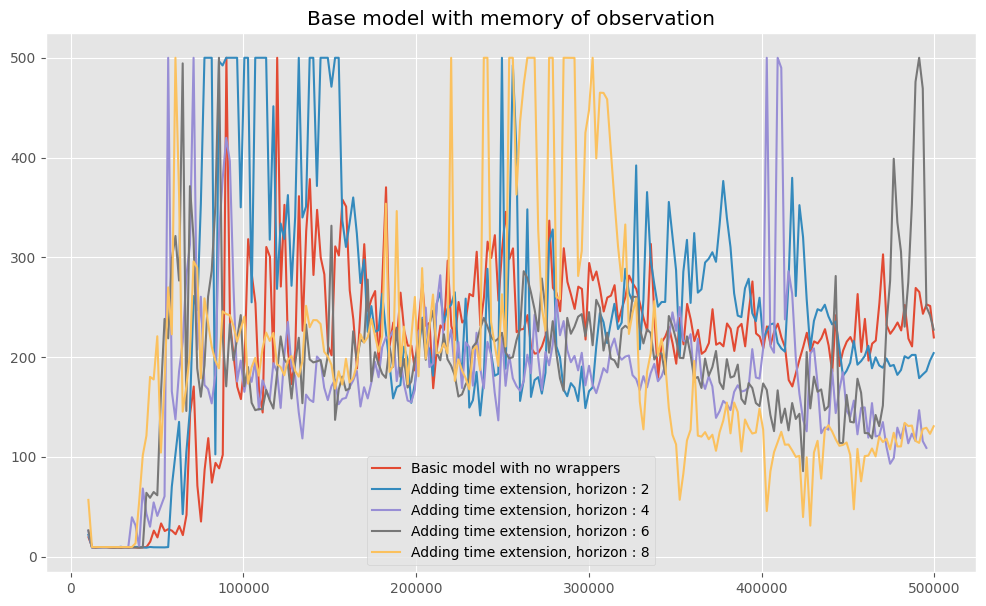

In [26]:
comparing_wrappers_with_base_model(
    results_no_wrapper, 
    [results_time_extension_2,results_time_extension_4, results_time_extension_6, results_time_extension_8],
    ["Adding time extension, horizon : 2","Adding time extension, horizon : 4","Adding time extension, horizon : 6", "Adding time extension, horizon : 8"],
    fig_title="Base model with memory of observation"
)

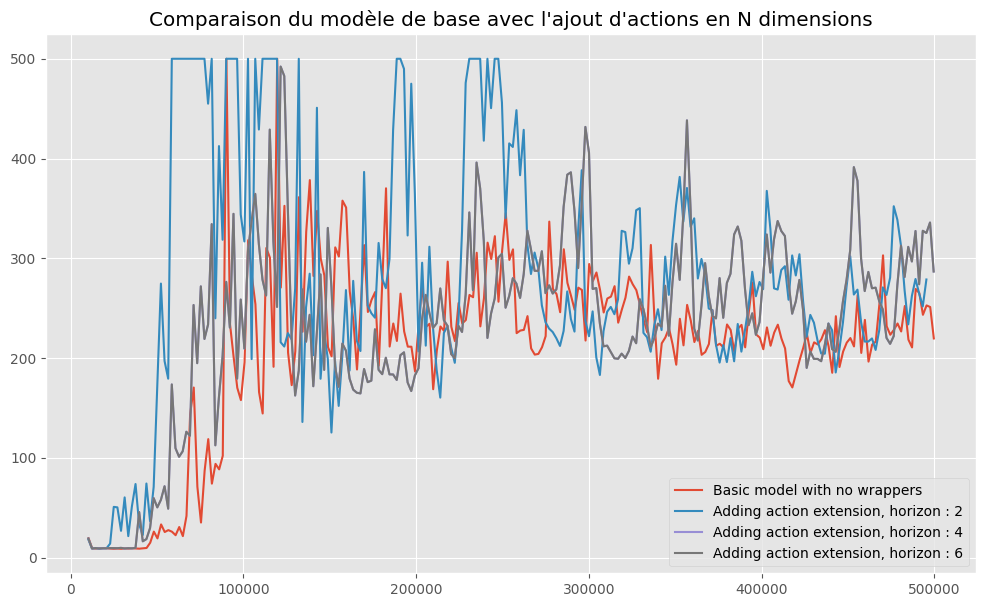

In [27]:
comparing_wrappers_with_base_model(
    results_no_wrapper, 
    [results_action_extension_2,results_action_extension_4, results_action_extension_4],
    ["Adding action extension, horizon : 2","Adding action extension, horizon : 4","Adding action extension, horizon : 6"],
    fig_title="Comparaison du modèle de base avec l'ajout d'actions en N dimensions"
)

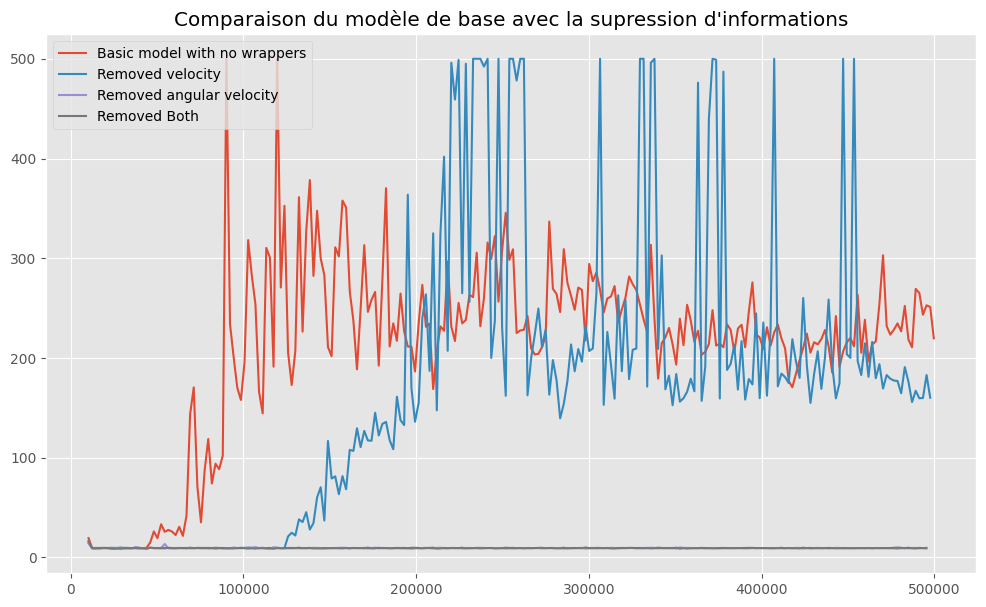

In [28]:
comparing_wrappers_with_base_model(
    results_no_wrapper, 
    [results_removed_index_1, results_removed_index_3, results_removed_index_3_1],
    ["Removed velocity", "Removed angular velocity", "Removed Both"],
    fig_title="Comparaison du modèle de base avec la supression d'informations"
)

In [29]:
from bbrl.stats import WelchTTest
plt.style.use("ggplot")

In [30]:
results_no_wrappers, results_time_extensions_2, results_action_extensions_2 = Utils.normalize_shapes(
    [results_no_wrappers,  results_time_extensions_2, results_action_extensions_2]
)

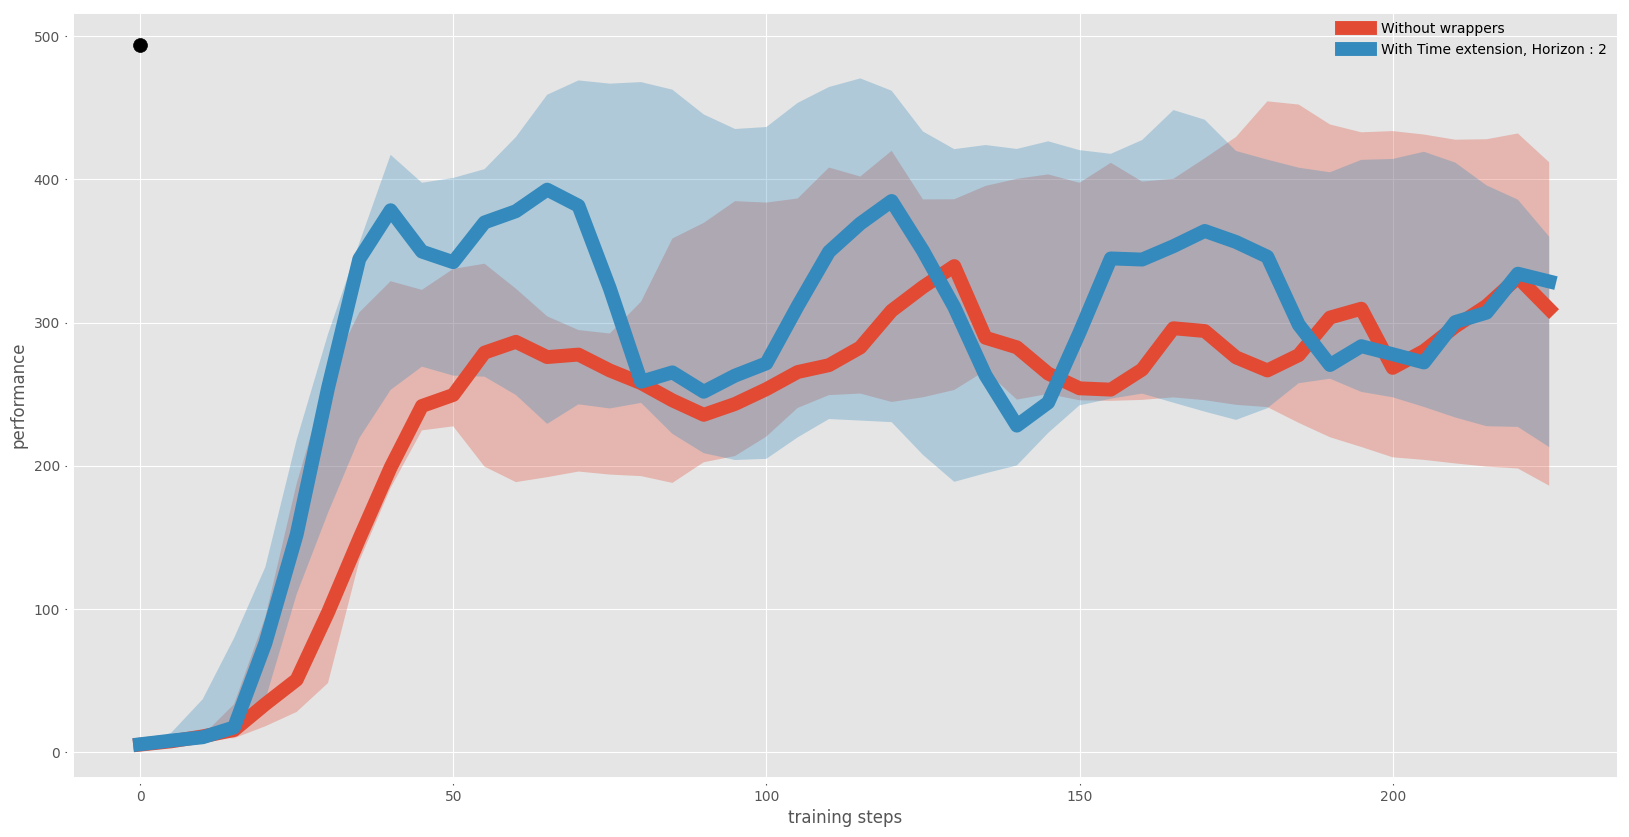

In [31]:
WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_no_wrappers]).T,
    torch.stack([torch.tensor(element[1]) for element in results_time_extensions_2]).T,
    legends="Without wrappers/With Time extension, Horizon : 2",
    save=False,
)

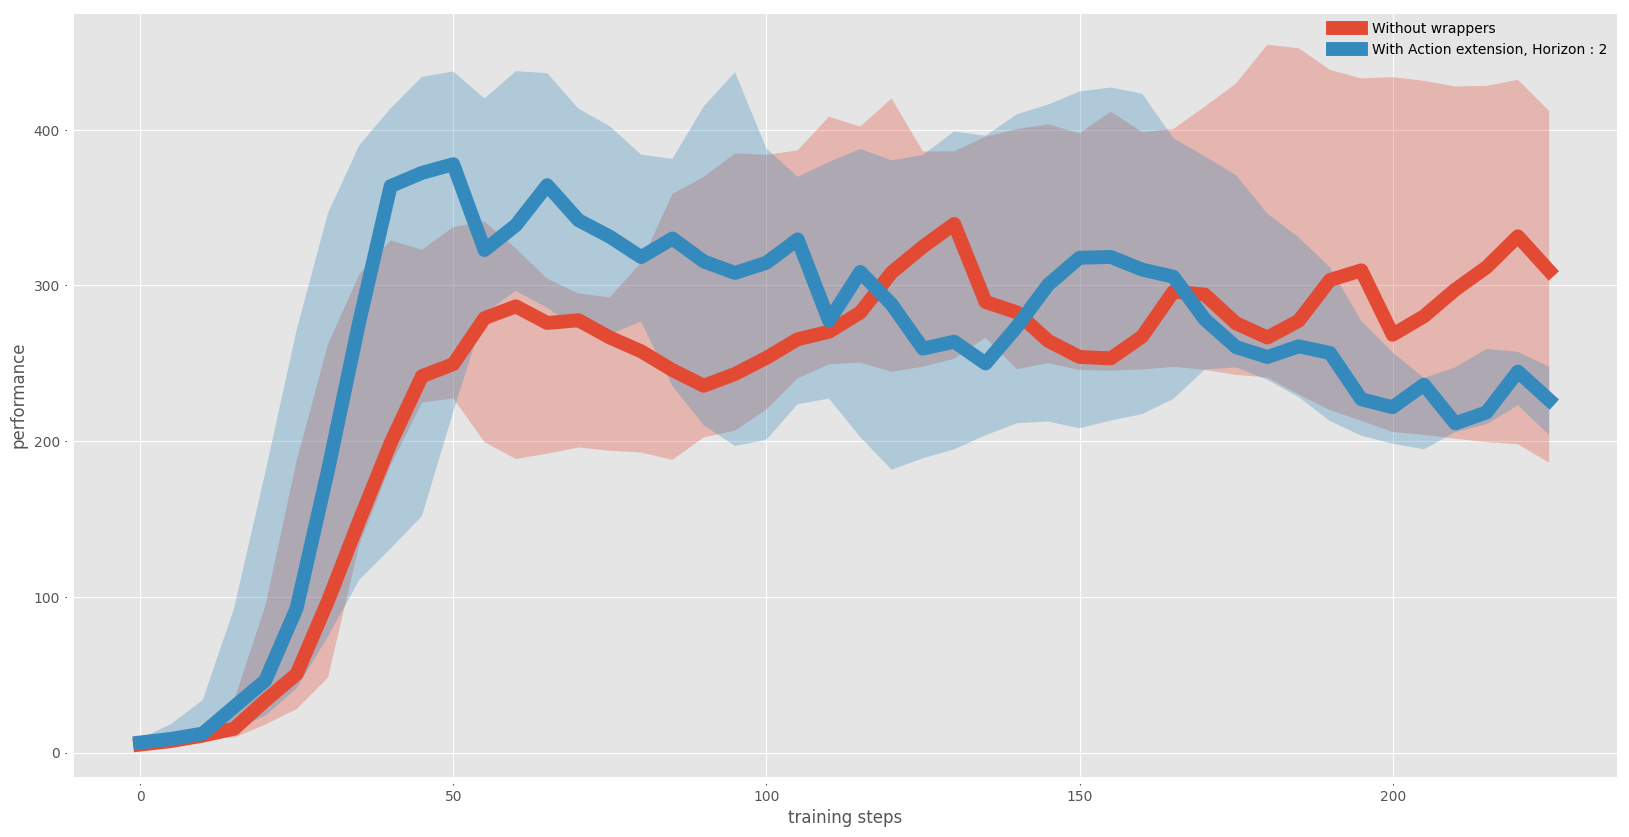

In [32]:
WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_no_wrappers]).T,
    torch.stack([torch.tensor(element[1]) for element in results_action_extensions_2]).T,
    legends="Without wrappers/With Action extension, Horizon : 2",
    save=False,
)

In [33]:
results_no_wrappers, results_time_extensions_4, results_action_extensions_4 = Utils.normalize_shapes(
    [results_no_wrappers,  results_time_extensions_4, results_action_extensions_4],
    skip_moving_average_indices=[0]
)

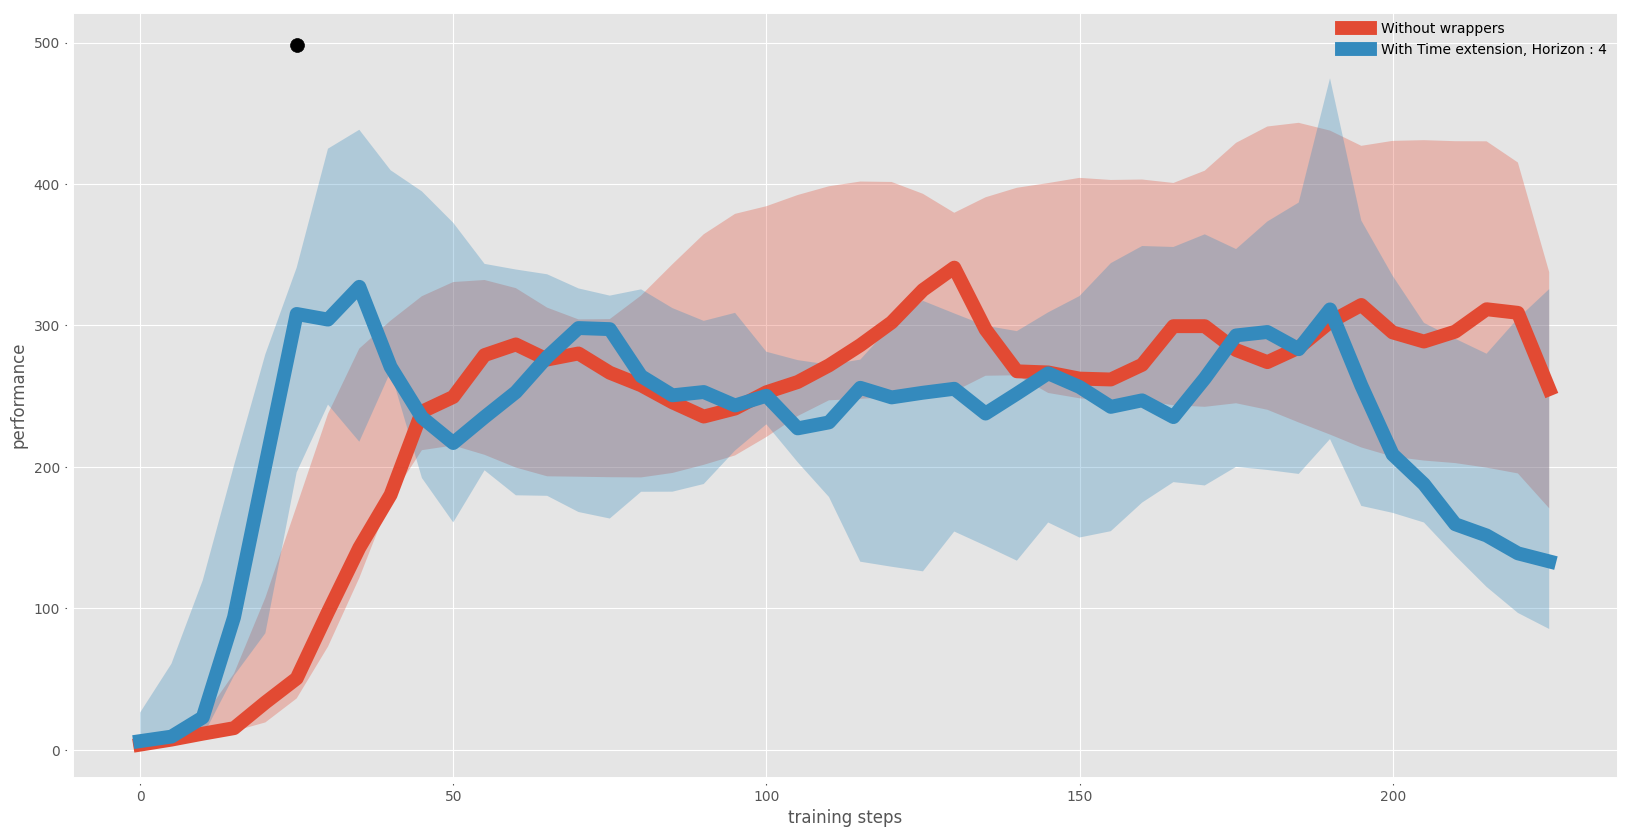

In [34]:
WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_no_wrappers]).T,
    torch.stack([torch.tensor(element[1]) for element in results_time_extensions_4]).T,
    legends="Without wrappers/With Time extension, Horizon : 4",
    save=False,
)

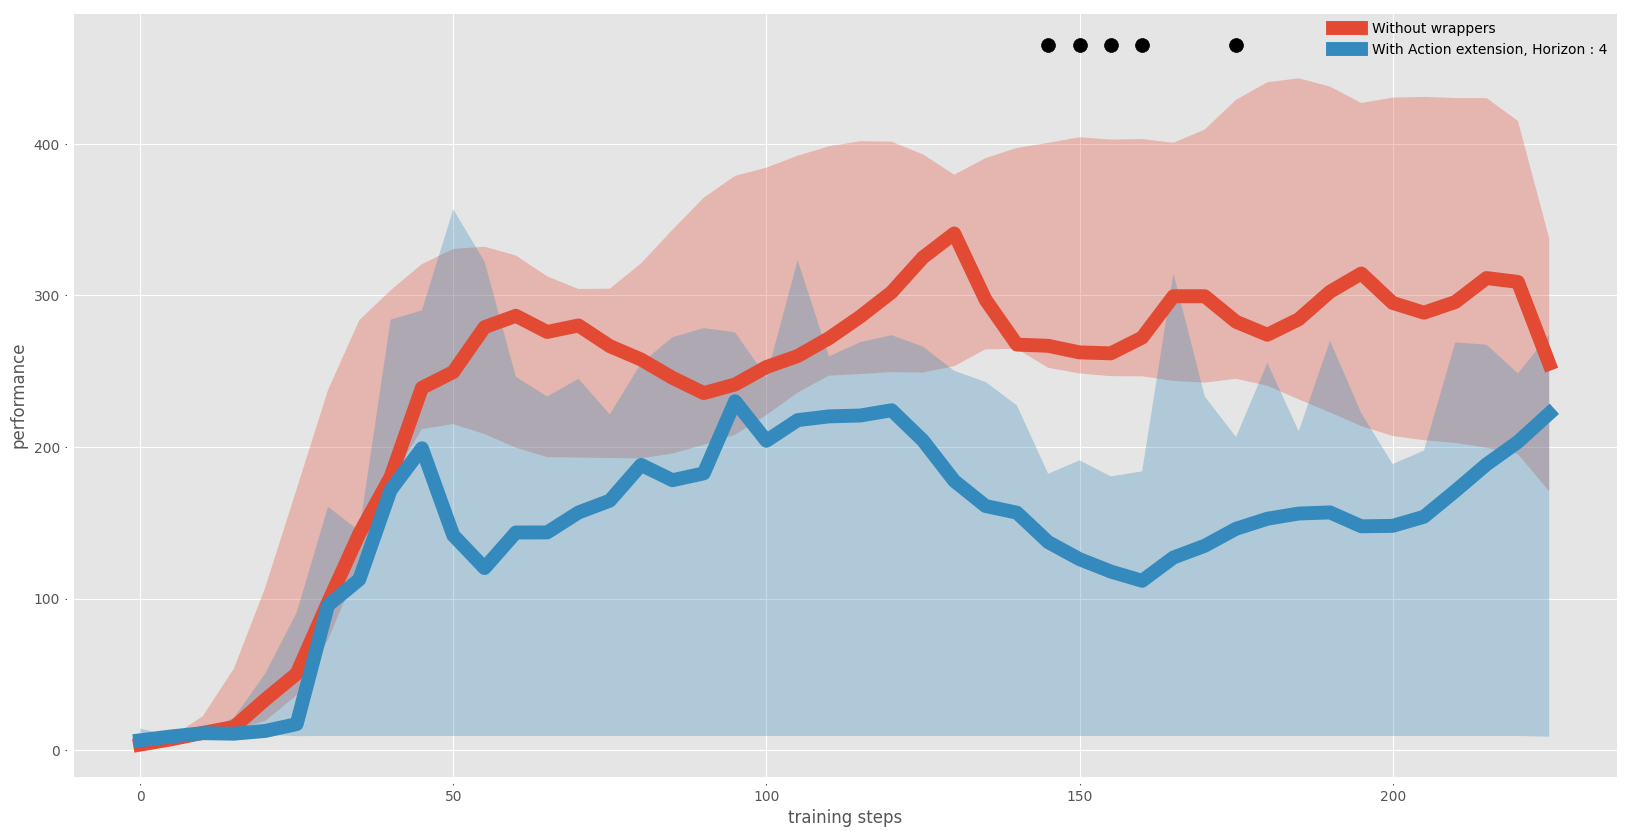

In [35]:
WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_no_wrappers]).T,
    torch.stack([torch.tensor(element[1]) for element in results_action_extensions_4]).T,
    legends="Without wrappers/With Action extension, Horizon : 4",
    save=False,
)

In [36]:
results_no_wrappers, results_time_extensions_6 = Utils.normalize_shapes(
    [results_no_wrappers,  results_time_extensions_6],
    skip_moving_average_indices=[0]
)

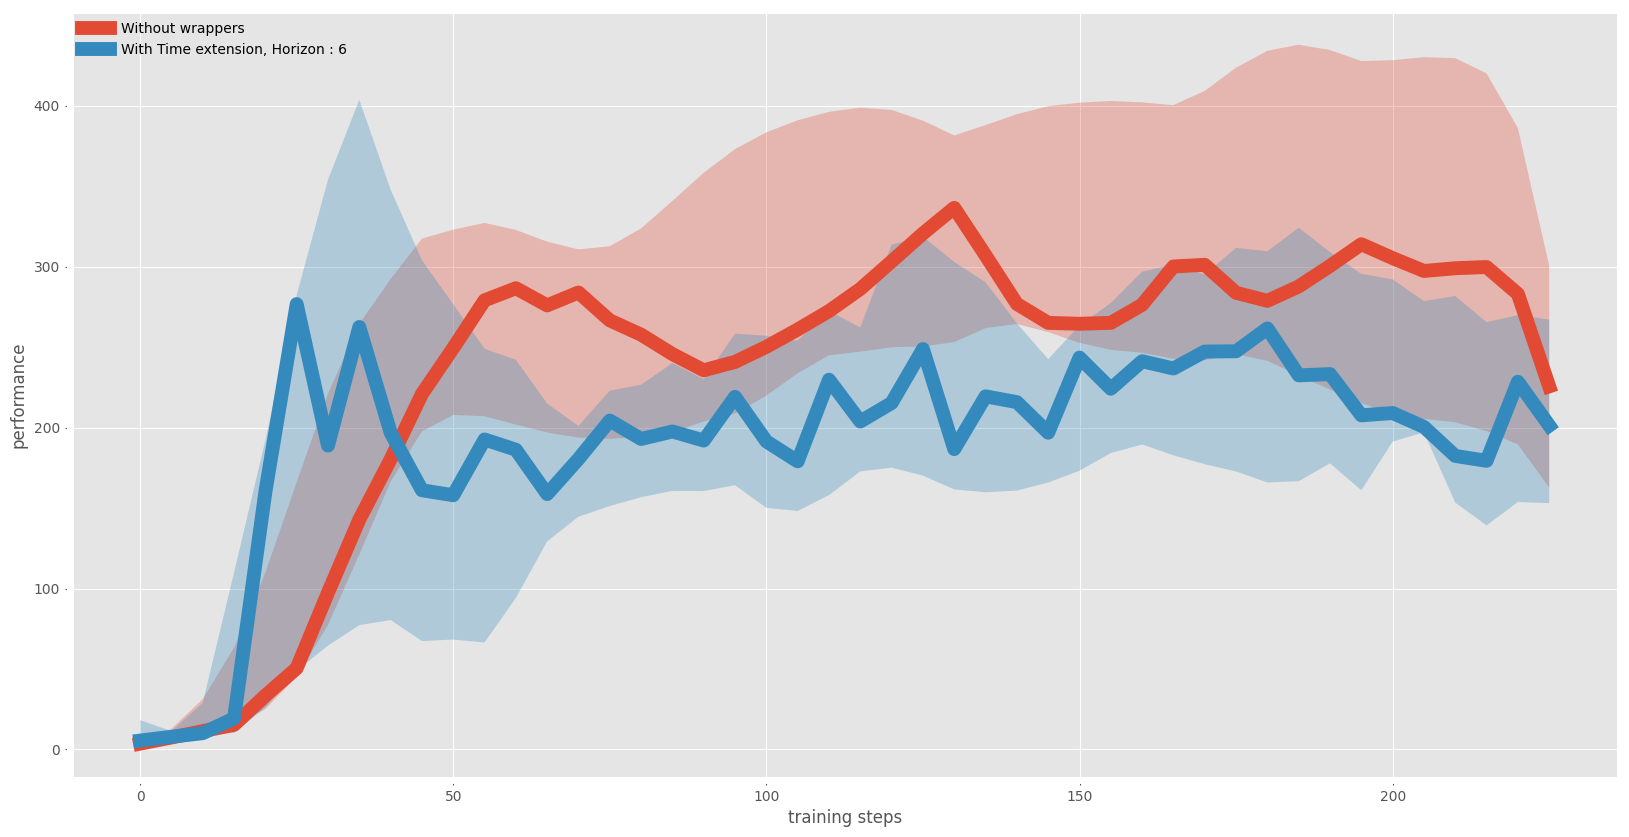

In [37]:
WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_no_wrappers]).T,
    torch.stack([torch.tensor(element[1]) for element in results_time_extensions_6]).T,
    legends="Without wrappers/With Time extension, Horizon : 6",
    save=False,
)

In [38]:
results_no_wrappers, results_time_extensions_8 = Utils.normalize_shapes(
    [results_no_wrappers,  results_time_extensions_8],
    skip_moving_average_indices=[0]
)

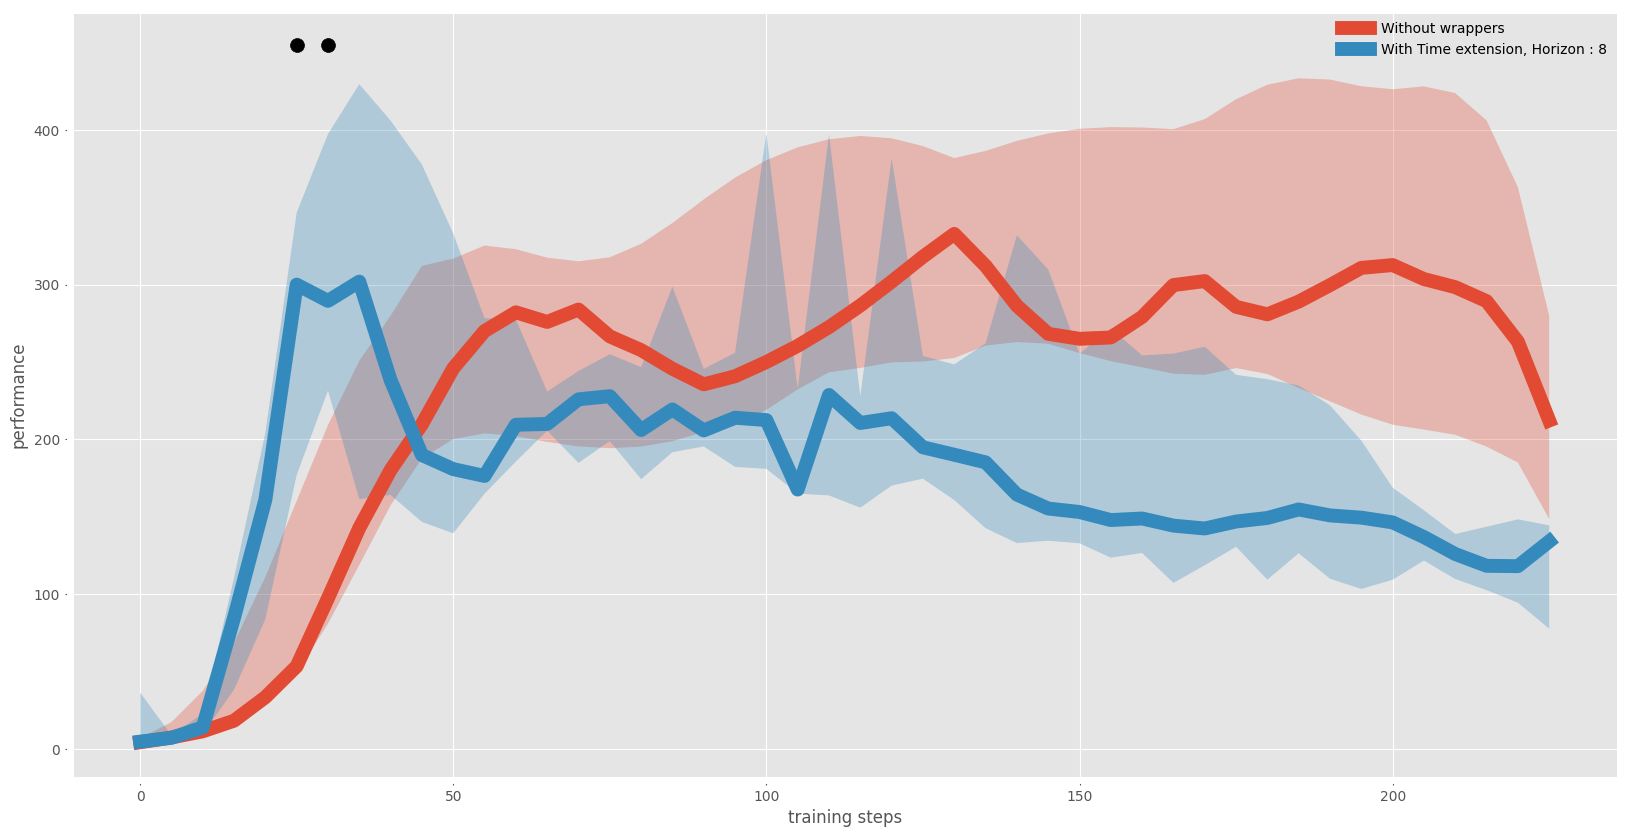

In [39]:
WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_no_wrappers]).T,
    torch.stack([torch.tensor(element[1]) for element in results_time_extensions_8]).T,
    legends="Without wrappers/With Time extension, Horizon : 8",
    save=False,
)

In [40]:
results_removed_indexs_1, results_removed_indexs_1_TE4 = Utils.normalize_shapes(
    [results_removed_indexs_1,  results_removed_indexs_1_TE4]
)

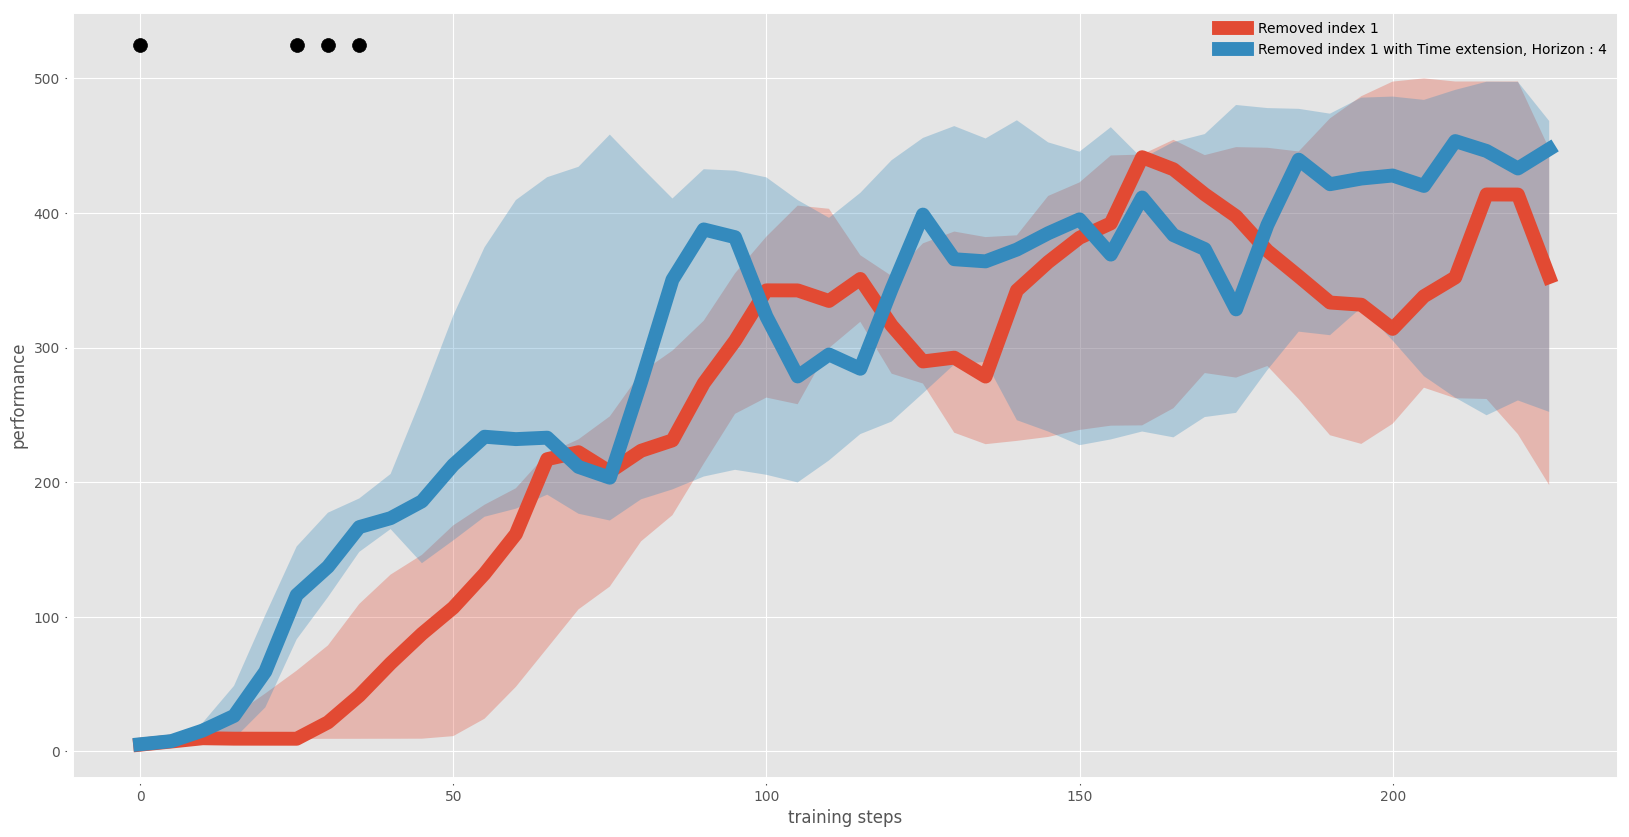

In [41]:
WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_removed_indexs_1]).T,
    torch.stack([torch.tensor(element[1]) for element in results_removed_indexs_1_TE4]).T,
    legends="Removed index 1/Removed index 1 with Time extension, Horizon : 4",
    save=False,
)

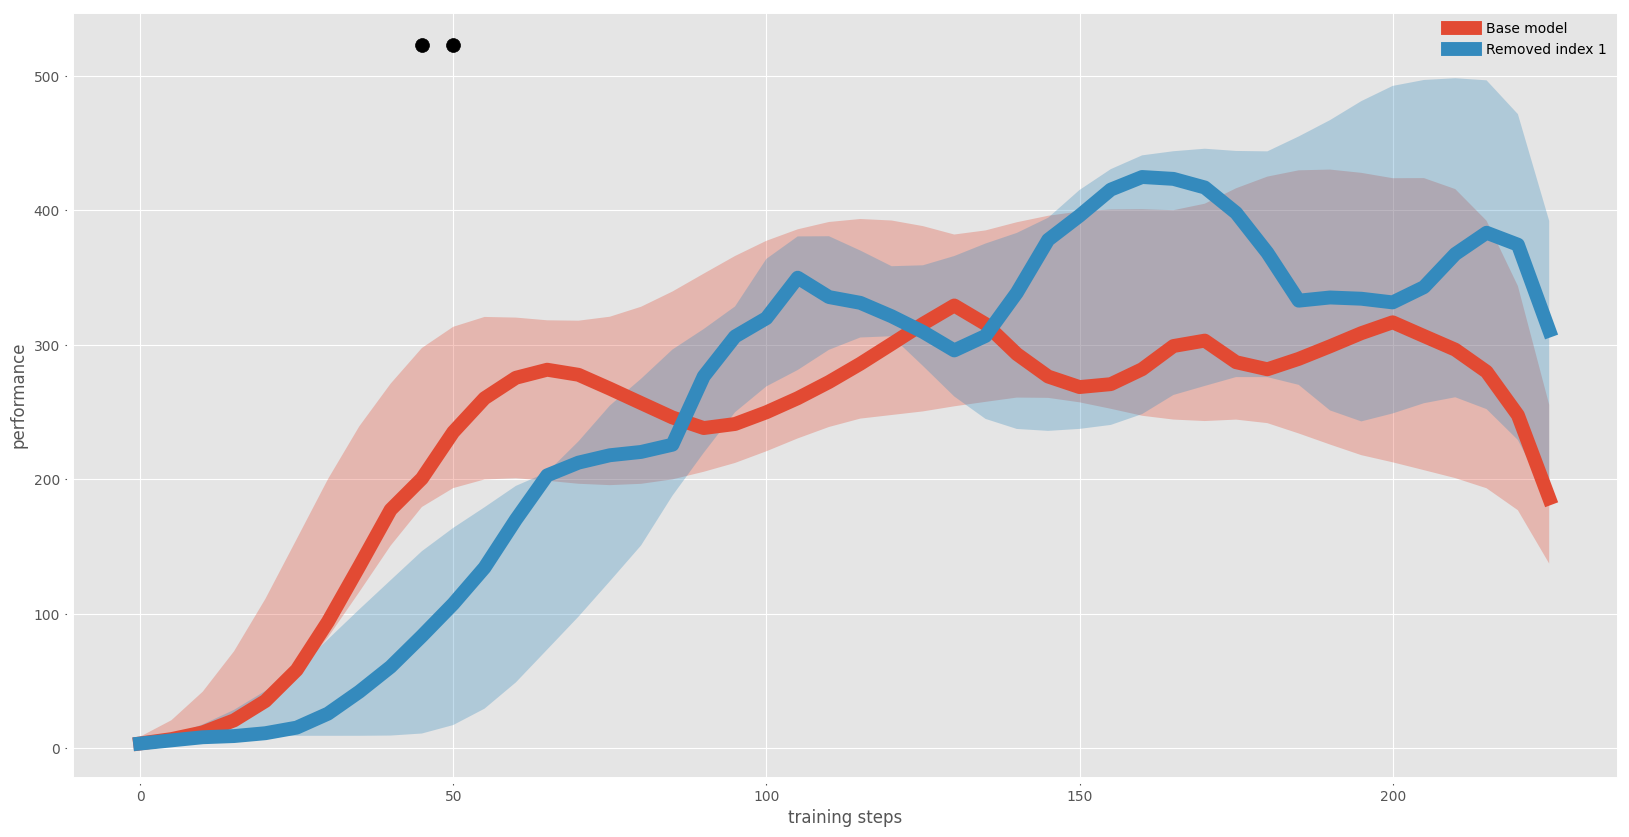

In [42]:
results_removed_indexs_1, results_no_wrappers = Utils.normalize_shapes(
    [results_removed_indexs_1,  results_no_wrappers],
    add_moving_average=True,
)

WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_no_wrappers]).T,
    torch.stack([torch.tensor(element[1]) for element in results_removed_indexs_1]).T,
    legends="Base model/Removed index 1",
    save=False,
)

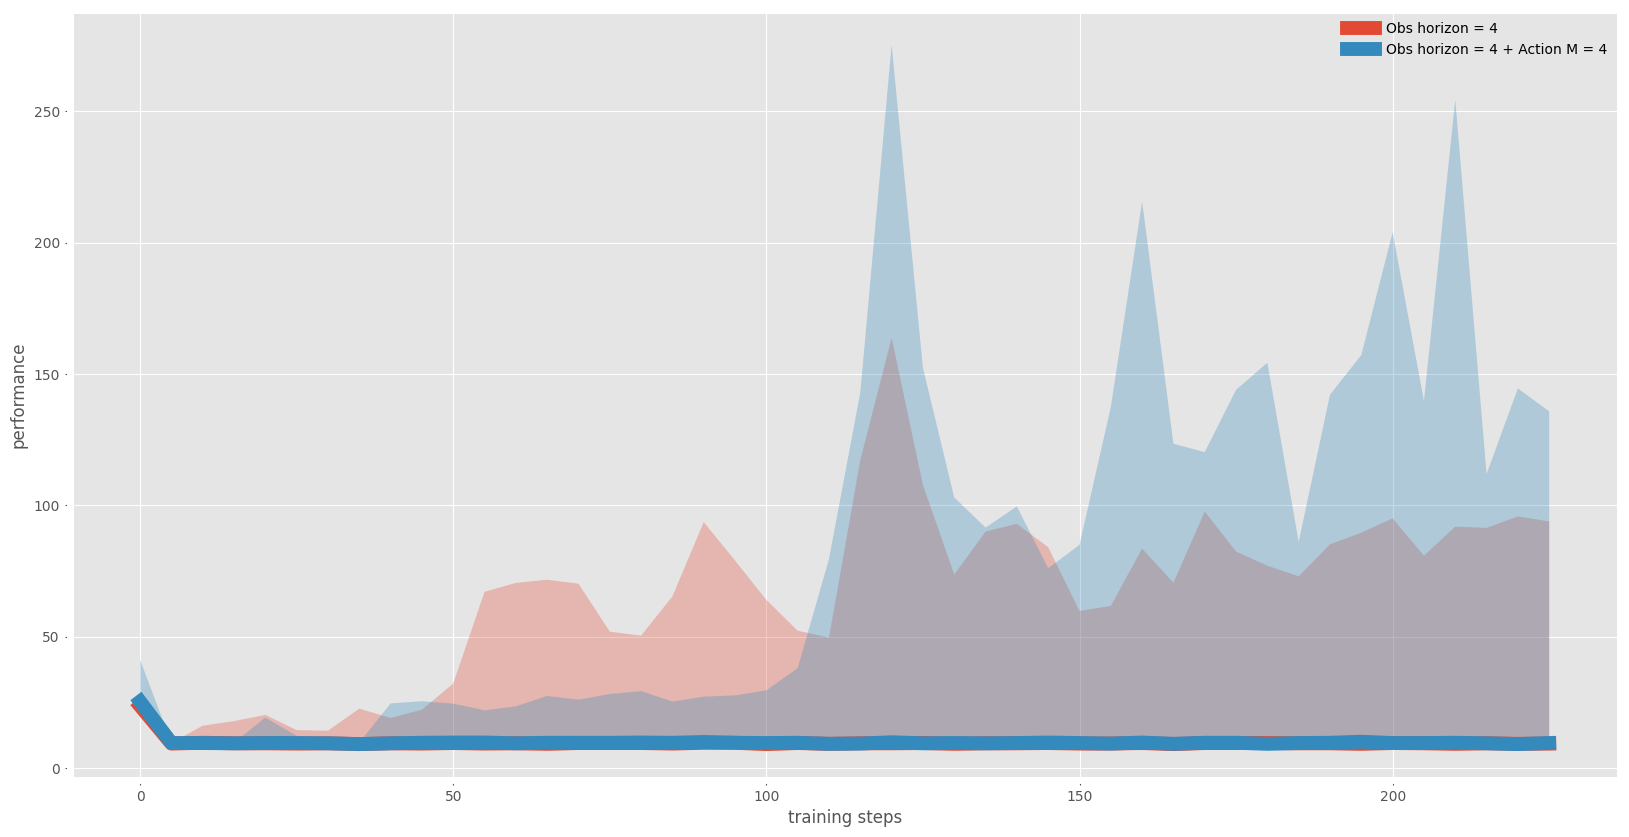

In [43]:
results_removed_indexs_3_1_TE4, results_removed_indexs_3_1_TE4_AT = Utils.normalize_shapes(
    [results_removed_indexs_3_1_TE4,  results_removed_indexs_3_1_TE4_AT],
    add_moving_average=False,
)

WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_removed_indexs_3_1_TE4]).T,
    torch.stack([torch.tensor(element[1]) for element in results_removed_indexs_3_1_TE4_AT]).T,
    legends="Obs horizon = 4/Obs horizon = 4 + Action M = 4",
    save=False,
)

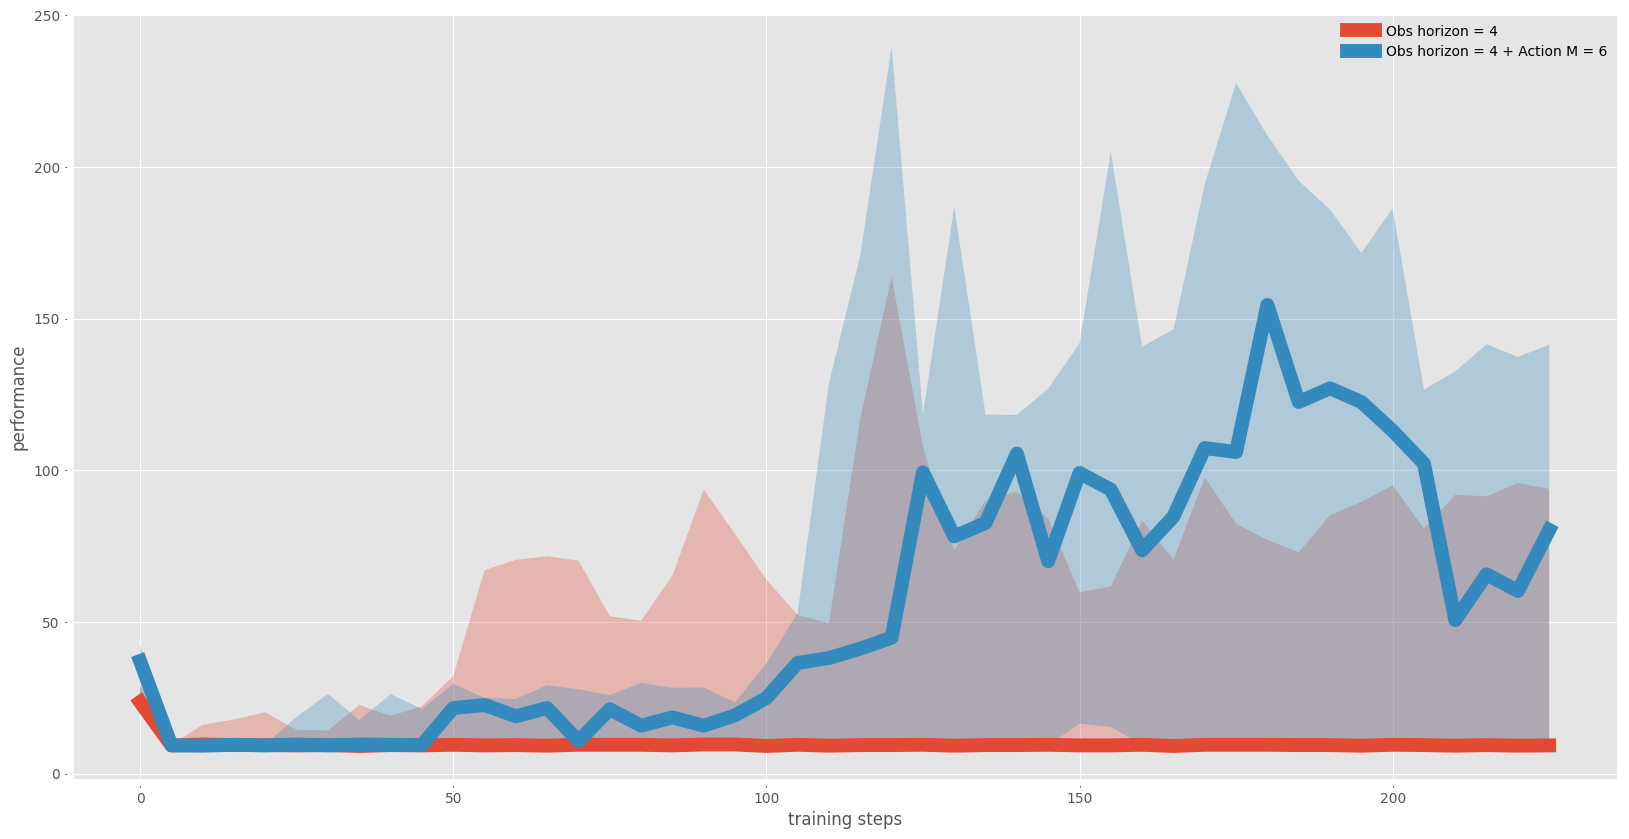

In [44]:
results_removed_indexs_3_1_TE4, results_removed_indexs_3_1_TE4_AT6 = Utils.normalize_shapes(
    [results_removed_indexs_3_1_TE4,  results_removed_indexs_3_1_TE4_AT6],
    add_moving_average=False,
)

WelchTTest().plot(
    torch.stack([torch.tensor(element[1]) for element in results_removed_indexs_3_1_TE4]).T,
    torch.stack([torch.tensor(element[1]) for element in results_removed_indexs_3_1_TE4_AT6]).T,
    legends="Obs horizon = 4/Obs horizon = 4 + Action M = 6",
    save=False,
)

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of all the choices you have made: the parameters you have set, the algorithms you have used, etc.,
    + the curves obtained when doing Exercise 3,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can extend the temporal horizon for the state memory and or action sequences beyond 2, and study the 
impact on learning performance and training time,
you can play with other partially observable environments, etc.
A great achievement would be to perform a comparison with the approach based on an LSTM.